In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, RepeatVector, TimeDistributed, Dense, MultiHeadAttention, Layer
from numpy.fft import fft
from scipy.stats import skew, kurtosis 
#from tensorflow_addons.layers import MultiHeadAttention
import matplotlib.pyplot as plt
import os
import struct
import glob
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, classification_report, accuracy_score
import time
totalMagnitude = 0
totalnumberofsamples = 0
def load_data(filepath):
    _, file_extension = os.path.splitext(filepath)
    
    if file_extension == '.csv':
        df = pd.read_csv(filepath)
        samples = df['your_column_name'].values
    elif file_extension == '.dat':
        #Looks like DAT is binary encoded added a b in r as rb
        with open(filepath, 'rb') as f:
            samples = f.readlines()
        samples = np.array([sample.strip() for sample in samples])
    else:
        raise ValueError(f"Unsupported file format: {file_extension}")
    
    return samples

def count_lines(filepath):
    with open(filepath, 'rb') as f:
        return sum(1 for _ in f)

class DataGenerator:        
    def __init__(self, filepath, batch_size, sequence_length, max_samples=None, for_training=True):
        self.filepath = filepath
        self.batch_size = batch_size
        self.sequence_length = sequence_length
        self.max_samples = max_samples
        self.for_training = for_training
        self.samples = []
        self.binary_file = open(self.filepath, 'rb')  # Initialize the binary_file here
        self.reset()

    def reset(self):
        self.total_samples_processed = 0
        _, self.file_extension = os.path.splitext(self.filepath)
        print(f"File extension detected: {self.file_extension}")  # Add this line


    def __iter__(self):
        self.binary_file.seek(0)  # reset file pointer
        self.samples = []
        return self
    
    def close(self):
        if not self.binary_file.closed:
            self.binary_file.close()

    def process_data(self, samples):
        real_parts = []
        imag_parts = []
        for sample in samples:
            try:
                cnum = complex(sample.replace('j', 'j'))
                real_parts.append(np.real(cnum))
                imag_parts.append(np.imag(cnum))
            except ValueError:
                continue

        real_parts = (real_parts - np.mean(real_parts)) / np.std(real_parts)
        imag_parts = (imag_parts - np.mean(imag_parts)) / np.std(imag_parts)

        X = [list(zip(real_parts[i:i+self.sequence_length], imag_parts[i:i+self.sequence_length])) for i in range(len(real_parts) - self.sequence_length)]
        return np.array(X)
    def process_data2(self, samples):
        # Convert samples list to a NumPy array and check the total number of samples
        samples_array = np.array(samples, dtype=np.complex64)
        total_samples = samples_array.size

        # Ensure that the total number of samples matches self.batch_size * self.sequence_length
        if total_samples != self.batch_size * self.sequence_length:
            # Handle this scenario: you might want to raise an error or handle it in some way
            raise ValueError("Total number of samples does not match batch_size * sequence_length")

        # Check for invalid values in samples_array before processing
        if np.isnan(samples_array).any() or np.isinf(samples_array).any():
            print(f"Invalid values found in samples_array: {samples_array}")
        # Reshape the samples array
        samples_array = samples_array.reshape(self.batch_size, self.sequence_length)
        #print('samples_array.shape:', samples_array.shape)

        # Apply FFT to convert time-domain signals into frequency domain
        samples_fft = fft(samples_array)
        #print('samples_fft.shape:', samples_fft.shape)

        # Extract real and imaginary parts
        real_parts = np.real(samples_fft)
        imag_parts = np.imag(samples_fft)

#         # Normalize the real and imaginary parts
#         real_parts = (real_parts - np.mean(real_parts, axis=1, keepdims=True)) / np.std(real_parts, axis=1, keepdims=True)
#         imag_parts = (imag_parts - np.mean(imag_parts, axis=1, keepdims=True)) / np.std(imag_parts, axis=1, keepdims=True)
        
        # Normalize the real and imaginary parts
        epsilon = 1e-10
        real_parts_mean = np.mean(real_parts, axis=1, keepdims=True)
        real_parts_std = np.std(real_parts, axis=1, keepdims=True)
        real_parts_std[real_parts_std == 0] = epsilon  # Avoid division by zero
        real_parts = (real_parts - real_parts_mean) / real_parts_std

        imag_parts_mean = np.mean(imag_parts, axis=1, keepdims=True)
        imag_parts_std = np.std(imag_parts, axis=1, keepdims=True)
        imag_parts_std[imag_parts_std == 0] = epsilon  # Avoid division by zero
        imag_parts = (imag_parts - imag_parts_mean) / imag_parts_std

        # Extract statistical features from the real and imaginary parts
        features = np.column_stack((
            np.mean(real_parts, axis=1),
            np.std(real_parts, axis=1),
            skew(real_parts, axis=1),
            kurtosis(real_parts, axis=1),
            np.mean(imag_parts, axis=1),
            np.std(imag_parts, axis=1),
            skew(imag_parts, axis=1),
            kurtosis(imag_parts, axis=1)
        ))

        # Reshape features to match the input shape of the model
        X = features.reshape(-1, self.sequence_length, features.shape[1])
        return X

    def __next__(self):
        chunksize = self.batch_size * self.sequence_length
        global totalMagnitude  # Access the global variable
        global totalnumberofsamples  # Access the global variable
        
        #if self.file_extension == '.dat':        
        samples = []
        while True:
            binary_data = self.binary_file.read(8)
            if not binary_data:
                break  # End of file
            decoded_data = struct.unpack('ff', binary_data)
            
            # Skip samples that are exactly zero (0 + 0j)
            if decoded_data[0] == 0 and decoded_data[1] == 0:
                continue

            # Convert the binary data to a complex number string
            decoded_line = f"{decoded_data[0]}+{decoded_data[1]}j\n" if decoded_data[1] >= 0 else f"{decoded_data[0]}{decoded_data[1]}j\n"
            samples.append(decoded_line)

            # Check if we have enough samples for a batch
            if len(samples) == chunksize:
                X_chunk = self.process_data2(samples)
                if self.for_training:
                    return X_chunk, X_chunk
                else:
                    return X_chunk
                # Clear samples for the next batch (optional, depends on your logic)
                samples = []

def plot_with_intrusions8(all_X_chunk_test, all_X_chunk_pred, all_intrusion_flags, sequence_length, save_path):
    for idx in range(0, len(all_X_chunk_test), sequence_length):
        sequence_idx = idx // sequence_length
        if all_intrusion_flags[sequence_idx]:
            plt.figure(figsize=(14, 6))
            time_steps = np.arange(idx * sequence_length, (idx + 1) * sequence_length)

            real_part_test = all_X_chunk_test[idx, :, 0].reshape(-1)
            imag_part_test = all_X_chunk_test[idx, :, 1].reshape(-1)
            real_part_pred = all_X_chunk_pred[idx, :, 0].reshape(-1)
            imag_part_pred = all_X_chunk_pred[idx, :, 1].reshape(-1)

            plt.plot(time_steps, real_part_test, 'b-', label='Original Real', linewidth=2)
            plt.plot(time_steps, real_part_pred, 'r--', label='Reconstructed Real', linewidth=2)
            plt.plot(time_steps, imag_part_test, 'g-', label='Original Imag', linewidth=2)
            plt.plot(time_steps, imag_part_pred, 'y--', label='Reconstructed Imag', linewidth=2)
            
            # Define where the fill should be applied (assuming the entire range for this example)
            where_fill = np.full_like(time_steps, True, dtype=bool)  # Fill the entire range
            plt.fill_between(time_steps, -3, 3, where=where_fill, color=(1, 0.5, 0.5), alpha=0.3, label='Intrusion Detected')

            #plt.fill_between(time_steps, -3, 3, where=True, color=(1, 0.5, 0.5), alpha=0.3, label='Intrusion Detected')
            
            # Enhancing font size and making bold
            plt.title(f'Original vs Reconstructed with Intrusion (Sequence {sequence_idx})', fontsize=18, fontweight='bold')
            plt.xlabel('Sample Index', fontsize=16, fontweight='bold')
            plt.ylabel('IQ Sample', fontsize=16, fontweight='bold')
            plt.legend(loc='lower right', fontsize=15)

            # Enhancing xtick and ytick labels
            for label in (plt.gca().get_xticklabels() + plt.gca().get_yticklabels()):
                label.set_fontsize(13)
                label.set_fontweight('bold')

            plt.tight_layout()

            filename = os.path.join(save_path, f'intrusion_sequence_{sequence_idx}.png')
            plt.savefig(filename)
            plt.close()

sequence_length = 10
#-------------------------------SelfAttention-RNN---------------------------------------
class SelfAttentionLayer(Layer):
    def __init__(self, num_heads, key_dim):
        super(SelfAttentionLayer, self).__init__()
        self.multi_head_attention = MultiHeadAttention(num_heads=num_heads, key_dim=key_dim)
    def call(self, inputs):
        return self.multi_head_attention(inputs, inputs, inputs)

model = Sequential()
# Input LSTM layer
model.add(LSTM(100, activation='relu', input_shape=(sequence_length, 8), return_sequences=True))  # Adjusted input_shape
# Self-attention layer
model.add(SelfAttentionLayer(num_heads=8, key_dim=100))
# Rest of the model remains the same
model.add(LSTM(50, activation='relu', return_sequences=False))
model.add(RepeatVector(sequence_length))
model.add(LSTM(50, activation='relu', return_sequences=True))
model.add(LSTM(100, activation='relu', return_sequences=True))
model.add(TimeDistributed(Dense(8)))  # Adjusted units in Dense layer

model.summary()
model.compile(optimizer='adam', loss='mse')
batch_size = 100

max_train_samples = 4000000  # I limit the train or can put None for whole data
train_steps = (max_train_samples) // (batch_size * sequence_length)
max_samples = 4000000  # Maximum samples to read (or None to read all)
max_test_samples = 4000000

# Example file patterns

num_pure_samples = count_lines('/home/mreza/5G accelerator/IQ_samples/data collected/5G_DL_IQ_no_jamming_0924.dat')
print('num_pure_samples:', num_pure_samples)
pure_file_pattern = '/home/mreza/5G accelerator/ID_MEC/data generator/pure_data/pure_iq_samples_*.csv'
mixed_file_pattern = '/home/mreza/5G accelerator/ID_MEC/data generator/mixed_data/mixed_iq_samples_*.csv'
pure_file_new = '/home/mreza/5G accelerator/ID_MEC/data generator/New Data-Collection/rx_IQ_pure'
mixed_file_new = '/home/mreza/5G accelerator/ID_MEC/data generator/New Data-Collection/rx_IQ_MIX'
pure_file_old = '/home/mreza/5G accelerator/IQ_samples/data collected/5G_DL_IQ_no_jamming_0924.dat'
mixed_file_old = '/home/mreza/5G accelerator/IQ_samples/data collected/5G_DL_IQ_with_periodic_jamming_0928_02.dat'
# train_gen_instance = CSVDataGenerator(pure_file_pattern, batch_size, sequence_length, 
#                                       max_samples, for_training=True)
# combined_gen_instance = CSVDataGenerator(mixed_file_pattern, batch_size, sequence_length, 
#                                          max_test_samples, for_training=False)

train_gen_instance = DataGenerator(pure_file_new,batch_size=batch_size, sequence_length=sequence_length, 
                                   max_samples=max_train_samples, for_training=True)
combined_gen_instance = DataGenerator(mixed_file_new,batch_size=batch_size, sequence_length=sequence_length, 
                                      for_training=False)

num_epochs = 20  # You can adjust the number of epochs as needed
steps_per_epoch = train_steps  # Assuming one epoch processes all the data
for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1}/{num_epochs}")
    train_gen_instance.reset()  # Reset the generator at the beginning of each epoch
    for step in range(steps_per_epoch):
        try:
            X_chunk, Y_chunk = next(train_gen_instance)
        except StopIteration:
            train_gen_instance.reset()  # Reset the generator when it runs out of data
            X_chunk, Y_chunk = next(train_gen_instance)

        loss = model.train_on_batch(X_chunk, Y_chunk)
        #print(f"Step {step + 1}/{steps_per_epoch}", end='\r')
        if step % 200 == 0:
            print(f"Step {step + 1}/{train_steps}, Loss: {loss}")
    print()
    
num_predictions = 2000  # or any other large number
print(f"Number of predictions to be performed: {num_predictions}")


reconstruction_errors = []
all_X_chunk_test = []
all_X_chunk_pred = []
all_intrusion_flags = []
prediction_times = []
try:
    for _ in range(num_predictions):
        print('prediction number:', _)
        start_time = time.time()
        X_chunk_test = next(combined_gen_instance)
        X_chunk_pred = model.predict(X_chunk_test)
        prediction_times.append(time.time() - start_time)
        chunk_errors = np.mean(np.square(X_chunk_test - X_chunk_pred), axis=1)
        reconstruction_errors.extend(chunk_errors)        
        all_X_chunk_test.append(X_chunk_test)
        all_X_chunk_pred.append(X_chunk_pred)
except StopIteration:
    print("All samples processed.")

reconstruction_error = np.array(reconstruction_errors)
print('reconstruction_error.shape:', reconstruction_error.shape)
print('Number of NaNs in reconstruction_error:', np.isnan(reconstruction_error).sum())

#---------------------------------------111-----------------------------------
#max_error_per_sequence = reconstruction_error.reshape(-1, 8).max(axis=1)  # Shape (num_predictions * batch_size * sequence_length,)
max_error_per_sequence = reconstruction_error.max(axis=1) # Max error for each sequence
print('max_error_per_sequence:', max_error_per_sequence)

#error_per_sequence = max_error_per_sequence.reshape(-1, sequence_length).mean(axis=1)  # Shape (num_predictions * batch_size,)
# Determine the threshold for intrusion
#threshold1 = np.percentile(error_per_sequence, 99.6)
threshold1 = np.percentile(max_error_per_sequence, 99.6)
print('threshold1:', threshold1)
threshold2 = np.percentile(reconstruction_error, 95)
print('threshold percentile:', threshold2)

#is_intrusion_detected = error_per_sequence > threshold1  # Boolean array for sequences, shape (num_predictions * batch_size,)
is_intrusion_detected = max_error_per_sequence > threshold1  # Boolean array for sequences
print('len(is_intrusion_detected):', len(is_intrusion_detected))
print('is_intrusion_detected.shape:', is_intrusion_detected.shape)
#num_total_sequences = num_predictions * batch_size - num_predictions
num_total_sequences = len(max_error_per_sequence)
print('num_total_sequences:', num_total_sequences)
#---------------------------------------finish 111-----------------------------------
#flat_error_per_sequence = error_per_sequence.flatten()
flat_error_per_sequence = max_error_per_sequence.flatten()
# Determine if intrusion detected for each sequence
for error in flat_error_per_sequence:
    all_intrusion_flags.append(error > threshold1)    
all_X_chunk_test = np.concatenate(all_X_chunk_test, axis=0)
all_X_chunk_pred = np.concatenate(all_X_chunk_pred, axis=0)
#save_path = 'C:\\Users\\Mohammadreza\\Desktop\\My Class\\Proj-DC\\My Works\\My Papers\\intrusion\\data generator\\intrusion_detected'
#plot_with_intrusions8(all_X_chunk_test, all_X_chunk_pred, all_intrusion_flags, sequence_length, save_path)
#---------------------------------------------------------------------------
#jamming_detected = reconstruction_error > threshold2
jamming_detected = reconstruction_error > threshold1
train_gen_instance.close()
combined_gen_instance.close()
#Table to get insight
flattened_jamming_detected = jamming_detected.flatten()
real_part_detected = jamming_detected[:, 0]
imag_part_detected = jamming_detected[:, 1]

real_true_count = np.sum(real_part_detected)
real_false_count = len(real_part_detected) - real_true_count

imag_true_count = np.sum(imag_part_detected)
imag_false_count = len(imag_part_detected) - imag_true_count
# Overall
overall_true_count = np.sum(flattened_jamming_detected)
overall_false_count = len(flattened_jamming_detected) - overall_true_count
# Table-DataFrame
df = pd.DataFrame({
    'Part': ['Real', 'Imaginary', 'Overall'],
    'True Count': [real_true_count, imag_true_count, overall_true_count],
    'False Count': [real_false_count, imag_false_count, overall_false_count]
})
print(df)
num_jamming_detected = np.sum(jamming_detected)
print(f"Number of jamming sequences detected: {num_jamming_detected} out of {len(flattened_jamming_detected)} sequences")


2024-02-29 12:54:50.901997: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-02-29 12:54:50.903041: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-29 12:54:50.927800: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-29 12:54:50.928387: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-29 12:54:51.548156: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 10, 100)           43600     
                                                                 
 self_attention_layer (Self  (None, 10, 100)           322500    
 AttentionLayer)                                                 
                                                                 
 lstm_1 (LSTM)               (None, 50)                30200     
                                                                 
 repeat_vector (RepeatVecto  (None, 10, 50)            0         
 r)                                                              
                                                                 
 lstm_2 (LSTM)               (None, 10, 50)            20200     
                                                                 
 lstm_3 (LSTM)               (None, 10, 100)           6

Step 2401/4000, Loss: 0.10531340539455414
Step 2601/4000, Loss: 0.1419268101453781
Step 2801/4000, Loss: 0.14384986460208893
Step 3001/4000, Loss: 0.0934436097741127
Step 3201/4000, Loss: 0.11594792455434799
Step 3401/4000, Loss: 0.08881230652332306
Step 3601/4000, Loss: 0.09866305440664291
Step 3801/4000, Loss: 0.10324431955814362

Epoch 9/20
File extension detected: 
Step 1/4000, Loss: 0.09931312501430511
Step 201/4000, Loss: 0.4150563180446625
Step 401/4000, Loss: 0.11033596098423004
Step 601/4000, Loss: 0.06447061151266098
Step 801/4000, Loss: 0.09245521575212479
Step 1001/4000, Loss: 0.30937328934669495
Step 1201/4000, Loss: 0.10332278907299042
Step 1401/4000, Loss: 0.08713752776384354
Step 1601/4000, Loss: 0.09925103932619095
Step 1801/4000, Loss: 0.3317473232746124
Step 2001/4000, Loss: 0.07340878248214722
Step 2201/4000, Loss: 0.09535424411296844
Step 2401/4000, Loss: 0.0866619199514389
Step 2601/4000, Loss: 0.392503023147583
Step 2801/4000, Loss: 0.07031035423278809
Step 3001/

Step 201/4000, Loss: 0.03808404505252838
Step 401/4000, Loss: 0.016402950510382652
Step 601/4000, Loss: 0.02125409059226513
Step 801/4000, Loss: 0.01217842660844326
Step 1001/4000, Loss: 0.023820368573069572
Step 1201/4000, Loss: 0.018220001831650734
Step 1401/4000, Loss: 0.018288657069206238
Step 1601/4000, Loss: 0.027975942939519882
Step 1801/4000, Loss: 0.014674347825348377
Step 2001/4000, Loss: 0.02013634704053402
Step 2201/4000, Loss: 0.022137625142931938
Step 2401/4000, Loss: 0.033504143357276917
Step 2601/4000, Loss: 0.05070725083351135
Step 2801/4000, Loss: 0.015658710151910782
Step 3001/4000, Loss: 0.016783392056822777


2024-02-29 13:13:27.924556: W tensorflow/core/data/root_dataset.cc:286] Optimization loop failed: CANCELLED: Operation was cancelled


Step 3201/4000, Loss: 0.038835521787405014
Step 3401/4000, Loss: 0.01760970987379551
Step 3601/4000, Loss: 0.023478062823414803
Step 3801/4000, Loss: 0.016151314601302147

Epoch 19/20
File extension detected: 
Step 1/4000, Loss: 0.029549365863204002
Step 201/4000, Loss: 0.015504321083426476
Step 401/4000, Loss: 0.01916808821260929
Step 601/4000, Loss: 0.017422331497073174
Step 801/4000, Loss: 0.018851375207304955
Step 1001/4000, Loss: 0.02009900100529194
Step 1201/4000, Loss: 0.018146686255931854
Step 1401/4000, Loss: 0.012406869791448116
Step 1601/4000, Loss: 0.017243163660168648
Step 1801/4000, Loss: 0.019266847521066666
Step 2001/4000, Loss: 0.024644926190376282
Step 2201/4000, Loss: 0.03046116605401039
Step 2401/4000, Loss: 0.02587205171585083
Step 2601/4000, Loss: 0.02024701051414013
Step 2801/4000, Loss: 0.013942420482635498
Step 3001/4000, Loss: 0.05868936702609062
Step 3201/4000, Loss: 0.018345829099416733
Step 3401/4000, Loss: 0.010857776738703251
Step 3601/4000, Loss: 0.01410

prediction number: 84
1/1 [==============================] - 0s 18ms/step
prediction number: 85
1/1 [==============================] - 0s 13ms/step
prediction number: 86
1/1 [==============================] - 0s 17ms/step
prediction number: 87
1/1 [==============================] - 0s 12ms/step
prediction number: 88
1/1 [==============================] - 0s 27ms/step
prediction number: 89
1/1 [==============================] - 0s 13ms/step
prediction number: 90
1/1 [==============================] - 0s 20ms/step
prediction number: 91
1/1 [==============================] - 0s 12ms/step
prediction number: 92
1/1 [==============================] - 0s 13ms/step
prediction number: 93
1/1 [==============================] - 0s 17ms/step
prediction number: 94
1/1 [==============================] - 0s 12ms/step
prediction number: 95
1/1 [==============================] - 0s 21ms/step
prediction number: 96
1/1 [==============================] - 0s 13ms/step
prediction number: 97
1/1 [===========

1/1 [==============================] - 0s 13ms/step
prediction number: 194
1/1 [==============================] - 0s 15ms/step
prediction number: 195
1/1 [==============================] - 0s 13ms/step
prediction number: 196
1/1 [==============================] - 0s 13ms/step
prediction number: 197
1/1 [==============================] - 0s 17ms/step
prediction number: 198
1/1 [==============================] - 0s 12ms/step
prediction number: 199
1/1 [==============================] - 0s 18ms/step
prediction number: 200
1/1 [==============================] - 0s 13ms/step
prediction number: 201
1/1 [==============================] - 0s 20ms/step
prediction number: 202
1/1 [==============================] - 0s 16ms/step
prediction number: 203
1/1 [==============================] - 0s 19ms/step
prediction number: 204
1/1 [==============================] - 0s 12ms/step
prediction number: 205
1/1 [==============================] - 0s 19ms/step
prediction number: 206
1/1 [====================

1/1 [==============================] - 0s 12ms/step
prediction number: 303
1/1 [==============================] - 0s 13ms/step
prediction number: 304
1/1 [==============================] - 0s 17ms/step
prediction number: 305
1/1 [==============================] - 0s 13ms/step
prediction number: 306
1/1 [==============================] - 0s 17ms/step
prediction number: 307
1/1 [==============================] - 0s 13ms/step
prediction number: 308
1/1 [==============================] - 0s 17ms/step
prediction number: 309
1/1 [==============================] - 0s 13ms/step
prediction number: 310
1/1 [==============================] - 0s 26ms/step
prediction number: 311
1/1 [==============================] - 0s 13ms/step
prediction number: 312
1/1 [==============================] - 0s 19ms/step
prediction number: 313
1/1 [==============================] - 0s 12ms/step
prediction number: 314
1/1 [==============================] - 0s 13ms/step
prediction number: 315
1/1 [====================

1/1 [==============================] - 0s 12ms/step
prediction number: 412
1/1 [==============================] - 0s 17ms/step
prediction number: 413
1/1 [==============================] - 0s 13ms/step
prediction number: 414
1/1 [==============================] - 0s 17ms/step
prediction number: 415
1/1 [==============================] - 0s 13ms/step
prediction number: 416
1/1 [==============================] - 0s 26ms/step
prediction number: 417
1/1 [==============================] - 0s 13ms/step
prediction number: 418
1/1 [==============================] - 0s 22ms/step
prediction number: 419
1/1 [==============================] - 0s 12ms/step
prediction number: 420
1/1 [==============================] - 0s 16ms/step
prediction number: 421
1/1 [==============================] - 0s 14ms/step
prediction number: 422
1/1 [==============================] - 0s 15ms/step
prediction number: 423
1/1 [==============================] - 0s 13ms/step
prediction number: 424
1/1 [====================

1/1 [==============================] - 0s 14ms/step
prediction number: 521
1/1 [==============================] - 0s 17ms/step
prediction number: 522
1/1 [==============================] - 0s 13ms/step
prediction number: 523
1/1 [==============================] - 0s 19ms/step
prediction number: 524
1/1 [==============================] - 0s 13ms/step
prediction number: 525
1/1 [==============================] - 0s 26ms/step
prediction number: 526
1/1 [==============================] - 0s 13ms/step
prediction number: 527
1/1 [==============================] - 0s 20ms/step
prediction number: 528
1/1 [==============================] - 0s 13ms/step
prediction number: 529
1/1 [==============================] - 0s 13ms/step
prediction number: 530
1/1 [==============================] - 0s 12ms/step
prediction number: 531
1/1 [==============================] - 0s 12ms/step
prediction number: 532
1/1 [==============================] - 0s 18ms/step
prediction number: 533
1/1 [====================

1/1 [==============================] - 0s 16ms/step
prediction number: 630
1/1 [==============================] - 0s 13ms/step
prediction number: 631
1/1 [==============================] - 0s 18ms/step
prediction number: 632
1/1 [==============================] - 0s 13ms/step
prediction number: 633
1/1 [==============================] - 0s 17ms/step
prediction number: 634
1/1 [==============================] - 0s 13ms/step
prediction number: 635
1/1 [==============================] - 0s 18ms/step
prediction number: 636
1/1 [==============================] - 0s 13ms/step
prediction number: 637
1/1 [==============================] - 0s 26ms/step
prediction number: 638
1/1 [==============================] - 0s 13ms/step
prediction number: 639
1/1 [==============================] - 0s 26ms/step
prediction number: 640
1/1 [==============================] - 0s 15ms/step
prediction number: 641
1/1 [==============================] - 0s 30ms/step
prediction number: 642
1/1 [====================

1/1 [==============================] - 0s 13ms/step
prediction number: 739
1/1 [==============================] - 0s 16ms/step
prediction number: 740
1/1 [==============================] - 0s 12ms/step
prediction number: 741
1/1 [==============================] - 0s 26ms/step
prediction number: 742
1/1 [==============================] - 0s 12ms/step
prediction number: 743
1/1 [==============================] - 0s 15ms/step
prediction number: 744
1/1 [==============================] - 0s 12ms/step
prediction number: 745
1/1 [==============================] - 0s 12ms/step
prediction number: 746
1/1 [==============================] - 0s 18ms/step
prediction number: 747
1/1 [==============================] - 0s 13ms/step
prediction number: 748
1/1 [==============================] - 0s 18ms/step
prediction number: 749
1/1 [==============================] - 0s 13ms/step
prediction number: 750
1/1 [==============================] - 0s 18ms/step
prediction number: 751
1/1 [====================

1/1 [==============================] - 0s 17ms/step
prediction number: 848
1/1 [==============================] - 0s 13ms/step
prediction number: 849
1/1 [==============================] - 0s 25ms/step
prediction number: 850
1/1 [==============================] - 0s 13ms/step
prediction number: 851
1/1 [==============================] - 0s 14ms/step
prediction number: 852
1/1 [==============================] - 0s 12ms/step
prediction number: 853
1/1 [==============================] - 0s 12ms/step
prediction number: 854
1/1 [==============================] - 0s 17ms/step
prediction number: 855
1/1 [==============================] - 0s 12ms/step
prediction number: 856
1/1 [==============================] - 0s 15ms/step
prediction number: 857
1/1 [==============================] - 0s 13ms/step
prediction number: 858
1/1 [==============================] - 0s 27ms/step
prediction number: 859
1/1 [==============================] - 0s 13ms/step
prediction number: 860
1/1 [====================

1/1 [==============================] - 0s 24ms/step
prediction number: 957
1/1 [==============================] - 0s 17ms/step
prediction number: 958
1/1 [==============================] - 0s 23ms/step
prediction number: 959
1/1 [==============================] - 0s 15ms/step
prediction number: 960
1/1 [==============================] - 0s 22ms/step
prediction number: 961
1/1 [==============================] - 0s 15ms/step
prediction number: 962
1/1 [==============================] - 0s 15ms/step
prediction number: 963
1/1 [==============================] - 0s 28ms/step
prediction number: 964
1/1 [==============================] - 0s 14ms/step
prediction number: 965
1/1 [==============================] - 0s 30ms/step
prediction number: 966
1/1 [==============================] - 0s 16ms/step
prediction number: 967
1/1 [==============================] - 0s 32ms/step
prediction number: 968
1/1 [==============================] - 0s 16ms/step
prediction number: 969
1/1 [====================

1/1 [==============================] - 0s 26ms/step
prediction number: 1065
1/1 [==============================] - 0s 13ms/step
prediction number: 1066
1/1 [==============================] - 0s 19ms/step
prediction number: 1067
1/1 [==============================] - 0s 13ms/step
prediction number: 1068
1/1 [==============================] - 0s 13ms/step
prediction number: 1069
1/1 [==============================] - 0s 13ms/step
prediction number: 1070
1/1 [==============================] - 0s 13ms/step
prediction number: 1071
1/1 [==============================] - 0s 18ms/step
prediction number: 1072
1/1 [==============================] - 0s 13ms/step
prediction number: 1073
1/1 [==============================] - 0s 15ms/step
prediction number: 1074
1/1 [==============================] - 0s 13ms/step
prediction number: 1075
1/1 [==============================] - 0s 19ms/step
prediction number: 1076
1/1 [==============================] - 0s 13ms/step
prediction number: 1077
1/1 [=======

1/1 [==============================] - 0s 17ms/step
prediction number: 1173
1/1 [==============================] - 0s 13ms/step
prediction number: 1174
1/1 [==============================] - 0s 18ms/step
prediction number: 1175
1/1 [==============================] - 0s 13ms/step
prediction number: 1176
1/1 [==============================] - 0s 17ms/step
prediction number: 1177
1/1 [==============================] - 0s 13ms/step
prediction number: 1178
1/1 [==============================] - 0s 22ms/step
prediction number: 1179
1/1 [==============================] - 0s 13ms/step
prediction number: 1180
1/1 [==============================] - 0s 27ms/step
prediction number: 1181
1/1 [==============================] - 0s 13ms/step
prediction number: 1182
1/1 [==============================] - 0s 22ms/step
prediction number: 1183
1/1 [==============================] - 0s 13ms/step
prediction number: 1184
1/1 [==============================] - 0s 13ms/step
prediction number: 1185
1/1 [=======

1/1 [==============================] - 0s 13ms/step
prediction number: 1281
1/1 [==============================] - 0s 17ms/step
prediction number: 1282
1/1 [==============================] - 0s 13ms/step
prediction number: 1283
1/1 [==============================] - 0s 21ms/step
prediction number: 1284
1/1 [==============================] - 0s 18ms/step
prediction number: 1285
1/1 [==============================] - 0s 15ms/step
prediction number: 1286
1/1 [==============================] - 0s 12ms/step
prediction number: 1287
1/1 [==============================] - 0s 12ms/step
prediction number: 1288
1/1 [==============================] - 0s 13ms/step
prediction number: 1289
1/1 [==============================] - 0s 15ms/step
prediction number: 1290
1/1 [==============================] - 0s 17ms/step
prediction number: 1291
1/1 [==============================] - 0s 13ms/step
prediction number: 1292
1/1 [==============================] - 0s 18ms/step
prediction number: 1293
1/1 [=======

1/1 [==============================] - 0s 26ms/step
prediction number: 1389
1/1 [==============================] - 0s 14ms/step
prediction number: 1390
1/1 [==============================] - 0s 27ms/step
prediction number: 1391
1/1 [==============================] - 0s 15ms/step
prediction number: 1392
1/1 [==============================] - 0s 13ms/step
prediction number: 1393
1/1 [==============================] - 0s 19ms/step
prediction number: 1394
1/1 [==============================] - 0s 11ms/step
prediction number: 1395
1/1 [==============================] - 0s 17ms/step
prediction number: 1396
1/1 [==============================] - 0s 13ms/step
prediction number: 1397
1/1 [==============================] - 0s 17ms/step
prediction number: 1398
1/1 [==============================] - 0s 12ms/step
prediction number: 1399
1/1 [==============================] - 0s 17ms/step
prediction number: 1400
1/1 [==============================] - 0s 13ms/step
prediction number: 1401
1/1 [=======

1/1 [==============================] - 0s 13ms/step
prediction number: 1497
1/1 [==============================] - 0s 17ms/step
prediction number: 1498
1/1 [==============================] - 0s 12ms/step
prediction number: 1499
1/1 [==============================] - 0s 27ms/step
prediction number: 1500
1/1 [==============================] - 0s 13ms/step
prediction number: 1501
1/1 [==============================] - 0s 25ms/step
prediction number: 1502
1/1 [==============================] - 0s 13ms/step
prediction number: 1503
1/1 [==============================] - 0s 16ms/step
prediction number: 1504
1/1 [==============================] - 0s 12ms/step
prediction number: 1505
1/1 [==============================] - 0s 13ms/step
prediction number: 1506
1/1 [==============================] - 0s 14ms/step
prediction number: 1507
1/1 [==============================] - 0s 13ms/step
prediction number: 1508
1/1 [==============================] - 0s 17ms/step
prediction number: 1509
1/1 [=======

1/1 [==============================] - 0s 20ms/step
prediction number: 1605
1/1 [==============================] - 0s 13ms/step
prediction number: 1606
1/1 [==============================] - 0s 18ms/step
prediction number: 1607
1/1 [==============================] - 0s 14ms/step
prediction number: 1608
1/1 [==============================] - 0s 20ms/step
prediction number: 1609
1/1 [==============================] - 0s 13ms/step
prediction number: 1610
1/1 [==============================] - 0s 26ms/step
prediction number: 1611
1/1 [==============================] - 0s 17ms/step
prediction number: 1612
1/1 [==============================] - 0s 29ms/step
prediction number: 1613
1/1 [==============================] - 0s 16ms/step
prediction number: 1614
1/1 [==============================] - 0s 31ms/step
prediction number: 1615
1/1 [==============================] - 0s 12ms/step
prediction number: 1616
1/1 [==============================] - 0s 20ms/step
prediction number: 1617
1/1 [=======

1/1 [==============================] - 0s 18ms/step
prediction number: 1713
1/1 [==============================] - 0s 12ms/step
prediction number: 1714
1/1 [==============================] - 0s 18ms/step
prediction number: 1715
1/1 [==============================] - 0s 13ms/step
prediction number: 1716
1/1 [==============================] - 0s 27ms/step
prediction number: 1717
1/1 [==============================] - 0s 13ms/step
prediction number: 1718
1/1 [==============================] - 0s 26ms/step
prediction number: 1719
1/1 [==============================] - 0s 13ms/step
prediction number: 1720
1/1 [==============================] - 0s 18ms/step
prediction number: 1721
1/1 [==============================] - 0s 14ms/step
prediction number: 1722
1/1 [==============================] - 0s 13ms/step
prediction number: 1723
1/1 [==============================] - 0s 18ms/step
prediction number: 1724
1/1 [==============================] - 0s 12ms/step
prediction number: 1725
1/1 [=======

1/1 [==============================] - 0s 23ms/step
prediction number: 1821
1/1 [==============================] - 0s 19ms/step
prediction number: 1822
1/1 [==============================] - 0s 16ms/step
prediction number: 1823
1/1 [==============================] - 0s 18ms/step
prediction number: 1824
1/1 [==============================] - 0s 13ms/step
prediction number: 1825
1/1 [==============================] - 0s 17ms/step
prediction number: 1826
1/1 [==============================] - 0s 13ms/step
prediction number: 1827
1/1 [==============================] - 0s 18ms/step
prediction number: 1828
1/1 [==============================] - 0s 14ms/step
prediction number: 1829
1/1 [==============================] - 0s 18ms/step
prediction number: 1830
1/1 [==============================] - 0s 12ms/step
prediction number: 1831
1/1 [==============================] - 0s 22ms/step
prediction number: 1832
1/1 [==============================] - 0s 13ms/step
prediction number: 1833
1/1 [=======

1/1 [==============================] - 0s 18ms/step
prediction number: 1929
1/1 [==============================] - 0s 12ms/step
prediction number: 1930
1/1 [==============================] - 0s 17ms/step
prediction number: 1931
1/1 [==============================] - 0s 14ms/step
prediction number: 1932
1/1 [==============================] - 0s 18ms/step
prediction number: 1933
1/1 [==============================] - 0s 16ms/step
prediction number: 1934
1/1 [==============================] - 0s 20ms/step
prediction number: 1935
1/1 [==============================] - 0s 12ms/step
prediction number: 1936
1/1 [==============================] - 0s 25ms/step
prediction number: 1937
1/1 [==============================] - 0s 13ms/step
prediction number: 1938
1/1 [==============================] - 0s 26ms/step
prediction number: 1939
1/1 [==============================] - 0s 13ms/step
prediction number: 1940
1/1 [==============================] - 0s 27ms/step
prediction number: 1941
1/1 [=======

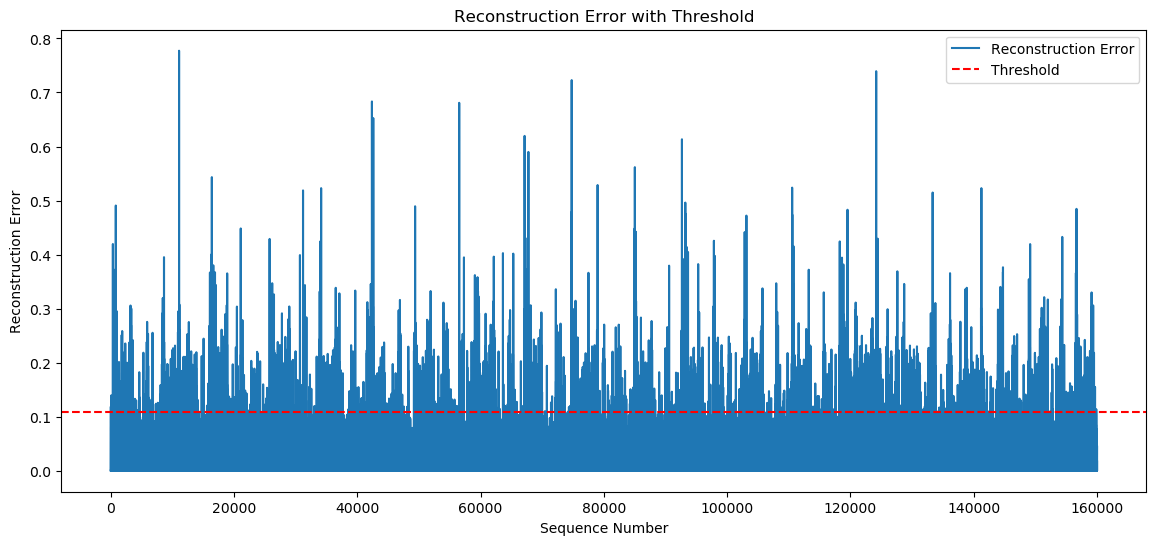

In [2]:
# Flatten the reconstruction_error to 1D
reconstruction_error_flat = reconstruction_error.flatten()
# reconstruction error
plt.figure(figsize=(14, 6))
plt.plot(reconstruction_error_flat, label='Reconstruction Error')
plt.axhline(y=threshold2, color='r', linestyle='--', label='Threshold')
plt.title('Reconstruction Error with Threshold')
plt.xlabel('Sequence Number')
plt.ylabel('Reconstruction Error')
plt.legend()
# plt.savefig('1-Reconstruction Error with Threshold.png')
# plt.close()
plt.show()


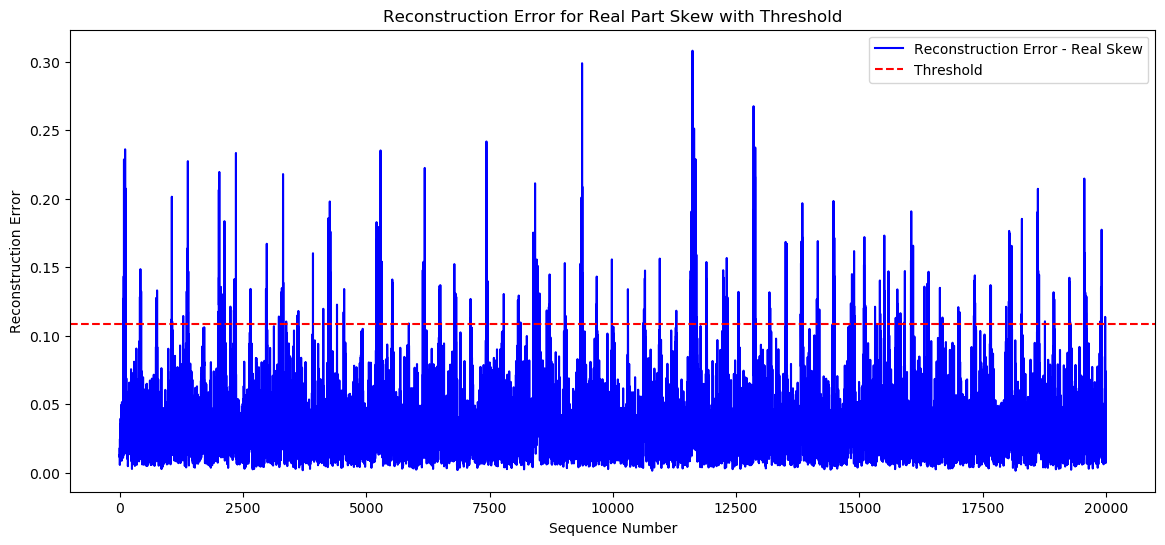

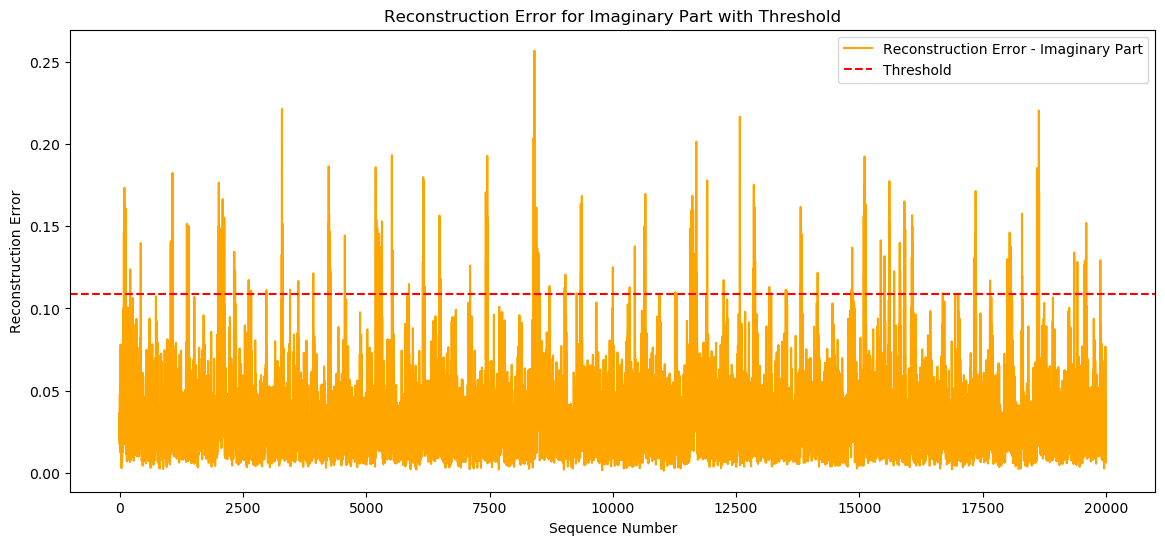

In [3]:
# reconstruction error
reconstruction_error_real_parts = reconstruction_error[:, 0]
reconstruction_error_real_std = reconstruction_error[:, 1]
reconstruction_error_real_skew = reconstruction_error[:, 2]
reconstruction_error_real_kurtosis = reconstruction_error[:, 3]
reconstruction_error_imag_parts = reconstruction_error[:, 4]
reconstruction_error_imag_std = reconstruction_error[:, 5]
reconstruction_error_imag_skew = reconstruction_error[:, 6]
reconstruction_error_imag_kurtosis = reconstruction_error[:, 7]

# Plot for Real Part
plt.figure(figsize=(14, 6))
plt.plot(reconstruction_error_real_skew, label='Reconstruction Error - Real Skew', color='blue')
plt.axhline(y=threshold2, color='r', linestyle='--', label='Threshold')
plt.title('Reconstruction Error for Real Part Skew with Threshold')
plt.xlabel('Sequence Number')
plt.ylabel('Reconstruction Error')
plt.legend()
# plt.savefig('2-Reconstruction Error for Real Part with Threshold.png')
# plt.close()
plt.show()

# Plot for Imaginary Part
plt.figure(figsize=(14, 6))
plt.plot(reconstruction_error_imag_skew, label='Reconstruction Error - Imaginary Part', color='orange')
plt.axhline(y=threshold2, color='r', linestyle='--', label='Threshold')
plt.title('Reconstruction Error for Imaginary Part with Threshold')
plt.xlabel('Sequence Number')
plt.ylabel('Reconstruction Error')
plt.legend()
# plt.savefig('3-Reconstruction Error for Imaginary Part with Threshold.png')
# plt.close()
plt.show()



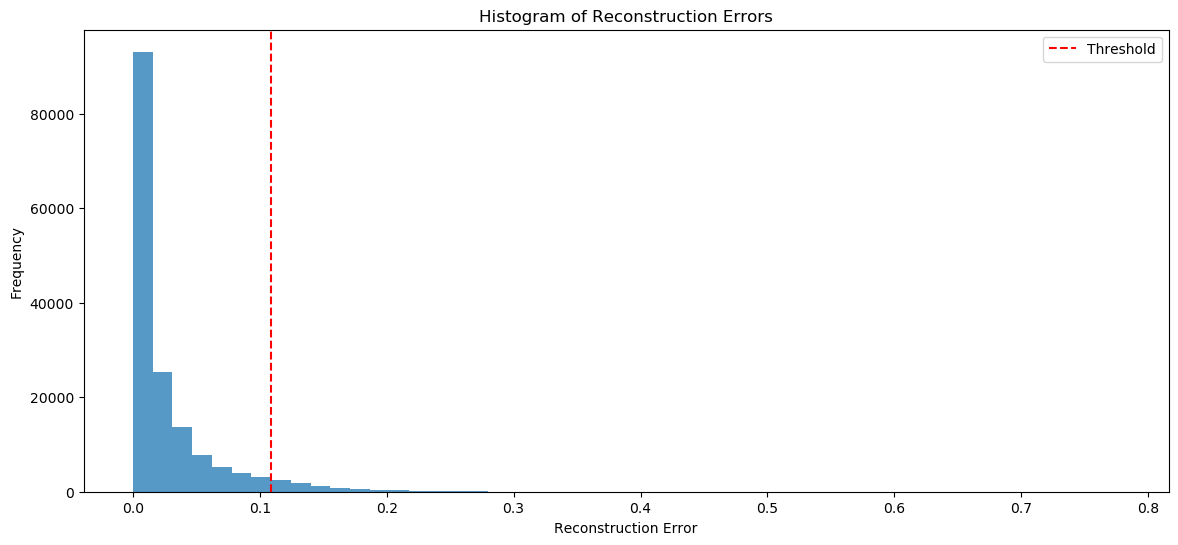

In [4]:
# Flatten the reconstruction_error to 1D
reconstruction_error_flat = reconstruction_error.flatten()
#Histogram of Reconstruction Errors:
plt.figure(figsize=(14, 6))
plt.hist(reconstruction_error_flat, bins=50, alpha=0.75)
plt.axvline(x=threshold2, color='r', linestyle='--', label='Threshold')
plt.title('Histogram of Reconstruction Errors')
plt.xlabel('Reconstruction Error')
plt.ylabel('Frequency')
plt.legend()
# plt.savefig('4-Histogram of Reconstruction Errors.png')
# plt.close()
plt.show()


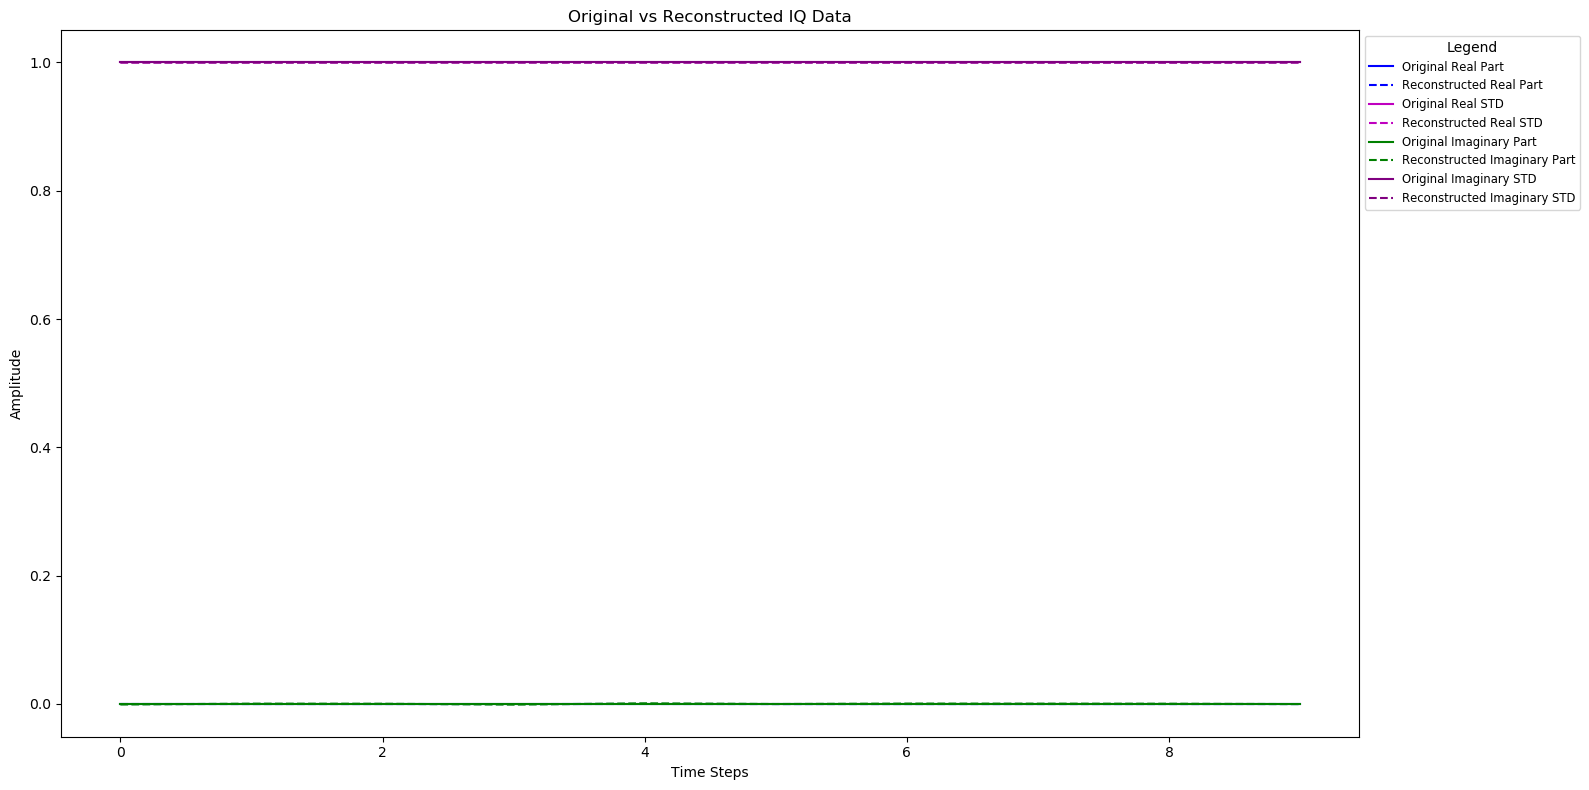

In [5]:
# real_parts, axis=1),
# np.std(real_parts, axis=1),
# skew(real_parts, axis=1),
# kurtosis(real_parts, axis=1),
# np.mean(imag_parts, axis=1),
# np.std(imag_parts, axis=1),
# skew(imag_parts, axis=1),
# kurtosis(imag_parts, axis=1)
#Time Series Plot of IQ Samples:
sample_index = np.random.choice(len(X_chunk_test))
original_sample = X_chunk_test[sample_index]
reconstructed_sample = X_chunk_pred[sample_index]

plt.figure(figsize=(16, 8))
plt.plot(original_sample[:, 0], 'b-', label='Original Real Part')
plt.plot(reconstructed_sample[:, 0], 'b--', label='Reconstructed Real Part')
plt.plot(original_sample[:, 1], 'm-', label='Original Real STD')
plt.plot(reconstructed_sample[:, 1], 'm--', label='Reconstructed Real STD')
# plt.plot(original_sample[:, 2], 'c-', label='Original Real Skew')
# plt.plot(reconstructed_sample[:, 2], 'c--', label='Reconstructed Real Skew')
# plt.plot(original_sample[:, 3], 'orange', label='Original Real Kurtosis')
# plt.plot(reconstructed_sample[:, 3], 'orange', label='Reconstructed Real Kurtosis', linestyle='--')

plt.plot(original_sample[:, 4], 'g-', label='Original Imaginary Part')
plt.plot(reconstructed_sample[:, 4], 'g--', label='Reconstructed Imaginary Part')
plt.plot(original_sample[:, 5], 'purple', label='Original Imaginary STD')
plt.plot(reconstructed_sample[:, 5], 'purple', label='Reconstructed Imaginary STD', linestyle='--')
# plt.plot(original_sample[:, 6], 'brown', label='Original Imaginary Skew')
# plt.plot(reconstructed_sample[:, 6], 'brown', label='Reconstructed Imaginary Skew', linestyle='--')
# plt.plot(original_sample[:, 7], 'pink', label='Original Imaginary Kurtosis')
# plt.plot(reconstructed_sample[:, 7], 'pink', label='Reconstructed Imaginary Kurtosis', linestyle='--')
plt.title('Original vs Reconstructed IQ Data')
plt.xlabel('Time Steps')
plt.ylabel('Amplitude')

# Place the legend outside the plot area
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize='small', title='Legend')

# Adjust layout to make room for the legend
plt.tight_layout()

plt.show()


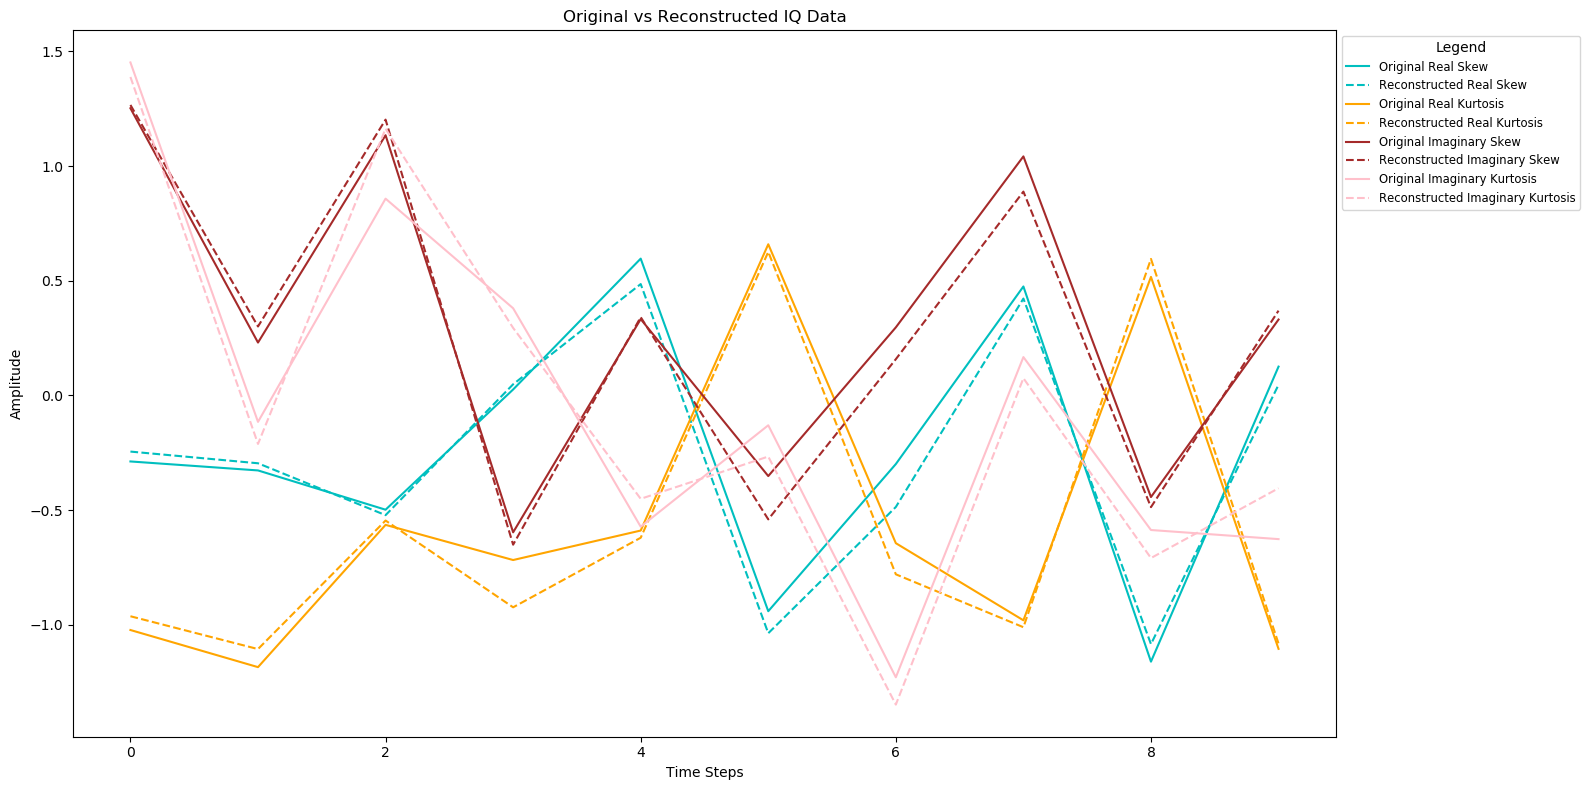

In [6]:
sample_index = np.random.choice(len(X_chunk_test))
original_sample = X_chunk_test[sample_index]
reconstructed_sample = X_chunk_pred[sample_index]

plt.figure(figsize=(16, 8))
# plt.plot(original_sample[:, 0], 'b-', label='Original Real Part')
# plt.plot(reconstructed_sample[:, 0], 'b--', label='Reconstructed Real Part')
# plt.plot(original_sample[:, 1], 'm-', label='Original Real STD')
# plt.plot(reconstructed_sample[:, 1], 'm--', label='Reconstructed Real STD')
plt.plot(original_sample[:, 2], 'c-', label='Original Real Skew')
plt.plot(reconstructed_sample[:, 2], 'c--', label='Reconstructed Real Skew')
plt.plot(original_sample[:, 3], 'orange', label='Original Real Kurtosis')
plt.plot(reconstructed_sample[:, 3], 'orange', label='Reconstructed Real Kurtosis', linestyle='--')

# plt.plot(original_sample[:, 4], 'g-', label='Original Imaginary Part')
# plt.plot(reconstructed_sample[:, 4], 'g--', label='Reconstructed Imaginary Part')
# plt.plot(original_sample[:, 5], 'purple', label='Original Imaginary STD')
# plt.plot(reconstructed_sample[:, 5], 'purple', label='Reconstructed Imaginary STD', linestyle='--')
plt.plot(original_sample[:, 6], 'brown', label='Original Imaginary Skew')
plt.plot(reconstructed_sample[:, 6], 'brown', label='Reconstructed Imaginary Skew', linestyle='--')
plt.plot(original_sample[:, 7], 'pink', label='Original Imaginary Kurtosis')
plt.plot(reconstructed_sample[:, 7], 'pink', label='Reconstructed Imaginary Kurtosis', linestyle='--')
plt.title('Original vs Reconstructed IQ Data')
plt.xlabel('Time Steps')
plt.ylabel('Amplitude')

# Place the legend outside the plot area
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize='small', title='Legend')

# Adjust layout to make room for the legend
plt.tight_layout()

plt.show()

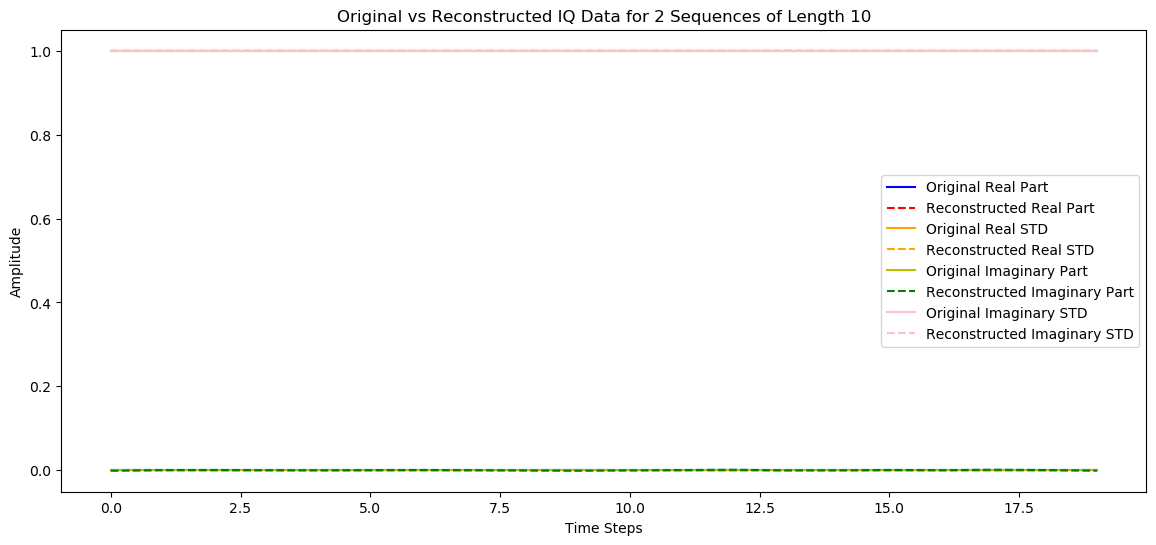

In [7]:
# # Define the number of sequences to plot together
n = 2  # Change this to desired number of sequences
sample_length = sequence_length * n

# Select a random starting sequence for plotting
sequence_index = np.random.choice(len(X_chunk_test) - n + 1)

# Extract and concatenate the original and reconstructed samples
original_sample = np.concatenate(X_chunk_test[sequence_index:sequence_index + n])
reconstructed_sample = np.concatenate(X_chunk_pred[sequence_index:sequence_index + n])

# Plot concatenated sequences
plt.figure(figsize=(14, 6))
plt.plot(original_sample[:, 0], 'b-', label='Original Real Part')
plt.plot(reconstructed_sample[:, 0], 'r--', label='Reconstructed Real Part')
plt.plot(original_sample[:, 1], 'orange', label='Original Real STD')
plt.plot(reconstructed_sample[:, 1], 'orange', label='Reconstructed Real STD', linestyle='--')

plt.plot(original_sample[:, 4], 'y-', label='Original Imaginary Part')
plt.plot(reconstructed_sample[:, 4], 'g--', label='Reconstructed Imaginary Part')
plt.plot(original_sample[:, 5], 'pink', label='Original Imaginary STD')
plt.plot(reconstructed_sample[:, 5], 'pink', label='Reconstructed Imaginary STD', linestyle='--')
plt.title(f'Original vs Reconstructed IQ Data for {n} Sequences of Length {sequence_length}')
plt.xlabel('Time Steps')
plt.ylabel('Amplitude')
plt.legend()
# plt.savefig('9-Original vs Reconstructed IQ Data for {n} Sequences of Length {sequence_length}.png')
# plt.close()
plt.show()


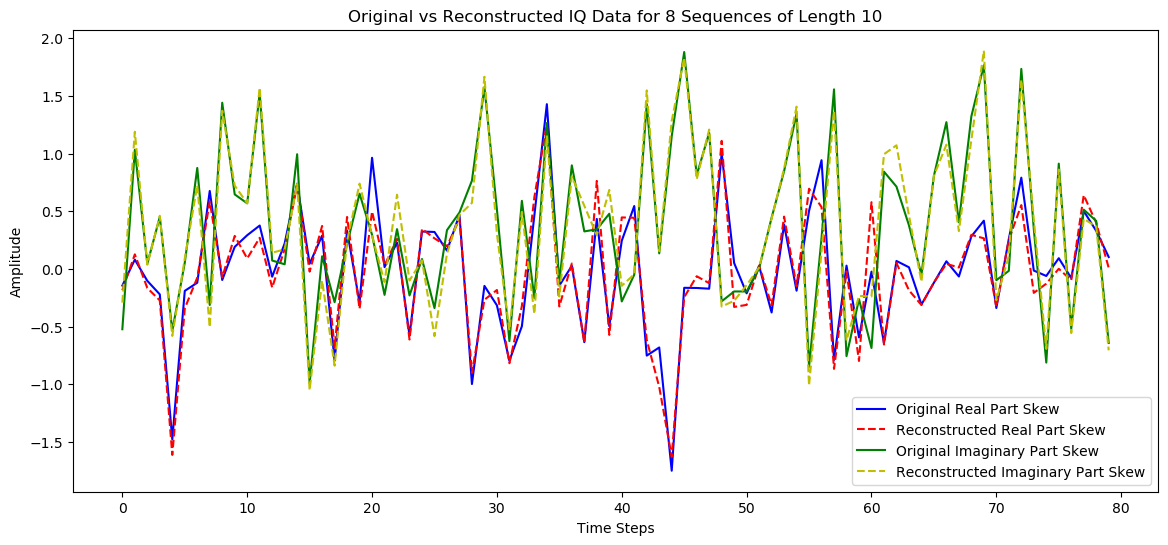

In [8]:
# Repeat for n = 9
n = 8  # Change this to desired number of sequences
sequence_index = np.random.choice(len(X_chunk_test) - n + 1)
original_sample = np.concatenate(X_chunk_test[sequence_index:sequence_index + n])
reconstructed_sample = np.concatenate(X_chunk_pred[sequence_index:sequence_index + n])

plt.figure(figsize=(14, 6))
plt.plot(original_sample[:, 2], 'b-', label='Original Real Part Skew')
plt.plot(reconstructed_sample[:, 2], 'r--', label='Reconstructed Real Part Skew')
plt.plot(original_sample[:, 6], 'g-', label='Original Imaginary Part Skew')
plt.plot(reconstructed_sample[:, 6], 'y--', label='Reconstructed Imaginary Part Skew')
plt.title(f'Original vs Reconstructed IQ Data for {n} Sequences of Length {sequence_length}')
plt.xlabel('Time Steps')
plt.ylabel('Amplitude')
plt.legend()
# plt.savefig('11-Original vs Reconstructed IQ Data for {n} Sequences of Length {sequence_length}.png')
# plt.close()
plt.show()


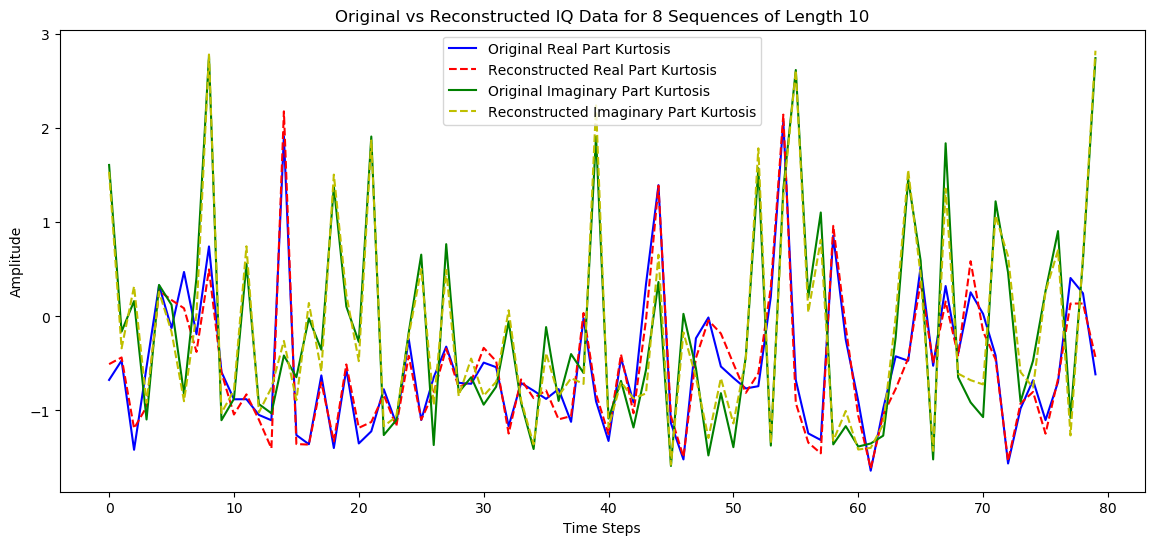

In [9]:
# Repeat for n = 9
n = 8  # Change this to desired number of sequences
sequence_index = np.random.choice(len(X_chunk_test) - n + 1)
original_sample = np.concatenate(X_chunk_test[sequence_index:sequence_index + n])
reconstructed_sample = np.concatenate(X_chunk_pred[sequence_index:sequence_index + n])

plt.figure(figsize=(14, 6))
plt.plot(original_sample[:, 3], 'b-', label='Original Real Part Kurtosis')
plt.plot(reconstructed_sample[:, 3], 'r--', label='Reconstructed Real Part Kurtosis')
plt.plot(original_sample[:, 7], 'g-', label='Original Imaginary Part Kurtosis')
plt.plot(reconstructed_sample[:, 7], 'y--', label='Reconstructed Imaginary Part Kurtosis')
plt.title(f'Original vs Reconstructed IQ Data for {n} Sequences of Length {sequence_length}')
plt.xlabel('Time Steps')
plt.ylabel('Amplitude')
plt.legend()
# plt.savefig('11-Original vs Reconstructed IQ Data for {n} Sequences of Length {sequence_length}.png')
# plt.close()
plt.show()

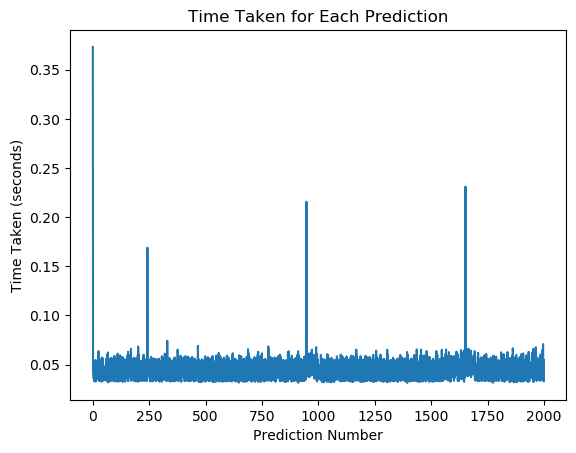

In [10]:
# Plotting the time taken for each prediction
plt.plot(prediction_times)
plt.xlabel('Prediction Number')
plt.ylabel('Time Taken (seconds)')
plt.title('Time Taken for Each Prediction')
plt.show()

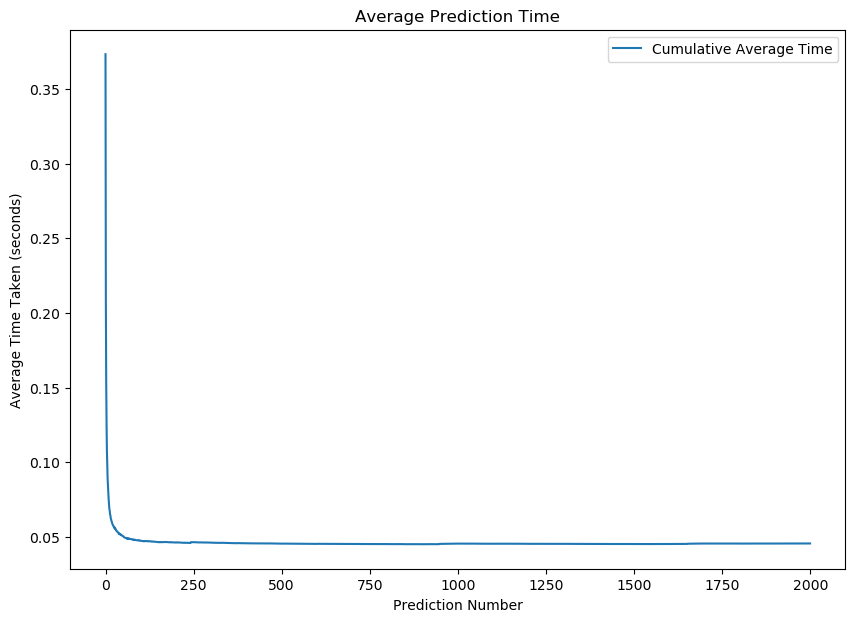

In [11]:
# Calculate cumulative average and minimum for each prediction step
cumulative_average = np.cumsum(prediction_times) / np.arange(1, len(prediction_times) + 1)
cumulative_minimum = np.minimum.accumulate(prediction_times)


# Plot for Average Prediction Time
plt.figure(figsize=(10, 7))  # Set the figure size for better readability
plt.plot(cumulative_average, label='Cumulative Average Time')
plt.xlabel('Prediction Number')
plt.ylabel('Average Time Taken (seconds)')
plt.title('Average Prediction Time')
plt.legend()
plt.show()


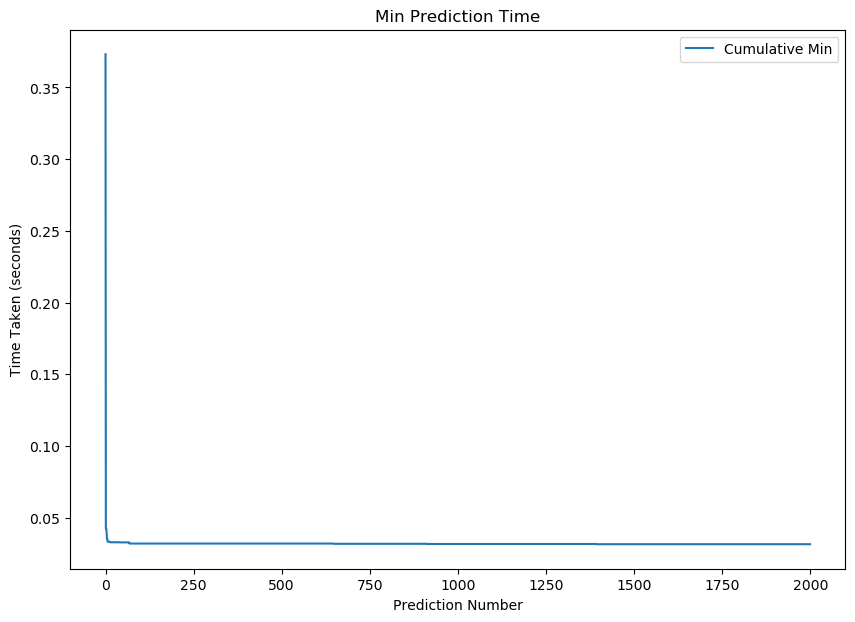

In [14]:
# Plot for Average Prediction Time
plt.figure(figsize=(10, 7))  # Set the figure size for better readability
plt.plot(cumulative_minimum, label='Cumulative Min')
plt.xlabel('Prediction Number')
plt.ylabel('Time Taken (seconds)')
plt.title('Min Prediction Time')
plt.legend()
plt.show()

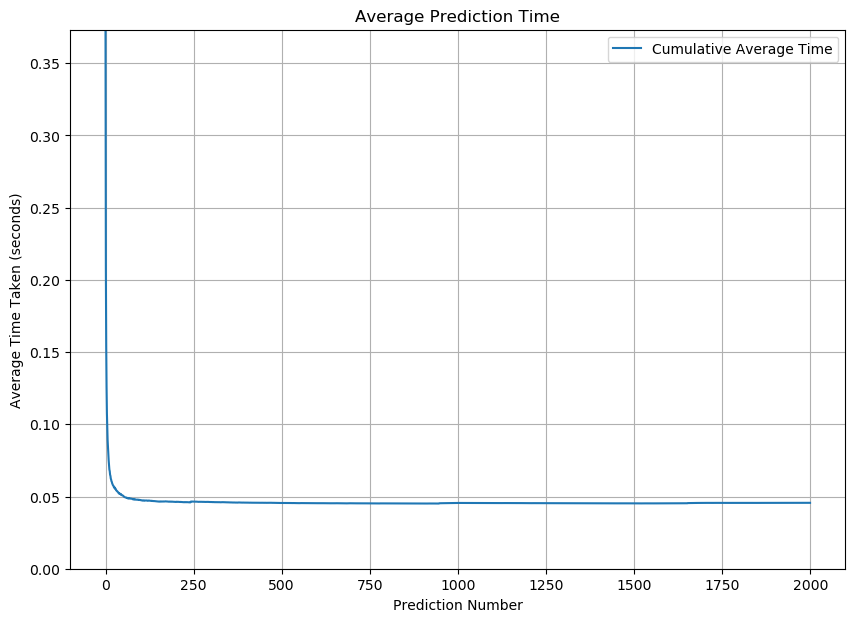

In [12]:
max_average_time = max(cumulative_average)

# Plot for Average Prediction Time with refined y-axis
plt.figure(figsize=(10, 7))  # Set the figure size for better readability
plt.plot(cumulative_average, label='Cumulative Average Time')
plt.xlabel('Prediction Number')
plt.ylabel('Average Time Taken (seconds)')
plt.title('Average Prediction Time')
plt.ylim(0, max_average_time)  # Set the y-axis to show from 0 to maximum average time
plt.legend()
plt.grid(True)  # Add grid for better precision viewing
plt.show()

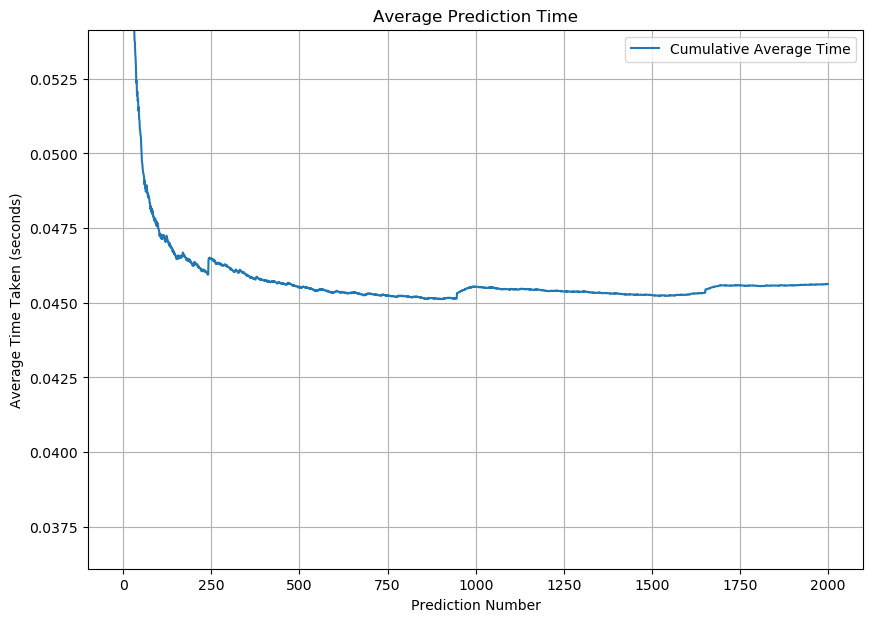

In [13]:
min_average_time = min(cumulative_average)
buffer = min_average_time * 0.2  # 10% of the minimum average time for buffer

# Plot for Average Prediction Time with refined y-axis around minimum
plt.figure(figsize=(10, 7))  # Set the figure size for better readability
plt.plot(cumulative_average, label='Cumulative Average Time')
plt.xlabel('Prediction Number')
plt.ylabel('Average Time Taken (seconds)')
plt.title('Average Prediction Time')
plt.ylim(min_average_time - buffer, min_average_time + buffer)  # Zoom in on the min average time
plt.legend()
plt.grid(True)  # Add grid for better precision viewing
plt.show()